# **Deep Learning - Assignment 1- CS23MTECH11026 - Bhargav Patel**

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from sklearn.model_selection import train_test_split
from torch import nn

## **IITH Logo - converting 4 channel (RGBA) to 3 channel (RGB)**

IITHlogo:  (1590, 1579, 4)
Converted to 3 channels:  (1590, 1579, 3)


(-0.5, 1578.5, 1589.5, -0.5)

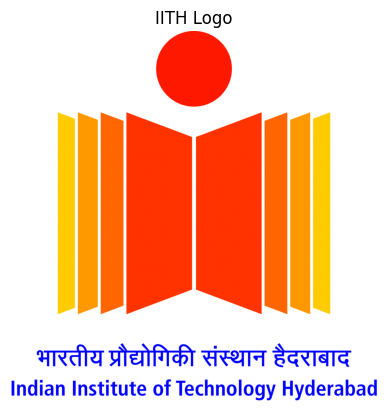

In [136]:
image_path = "IITHlogo.jpg"
image = mpimg.imread(image_path)
print("IITHlogo: ", image.shape)

# Simply ignoring the 4th channel (alpha)
iithlogo = image[:, :, :3] # selected the first 3 channels and removed the Alpha(last) channel
print("Converted to 3 channels: ", iithlogo.shape)

# Image normalization
nor_iithlogo = iithlogo / 255.0

plt.imshow(nor_iithlogo)
plt.title("IITH Logo")
plt.axis('off')

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


# **Question 1 - Convolution Function**
It accepts an image input, a filter kernel, stride, padding, and the nonlinear function. The function must convolve the input image (after padding if specified) with the
kernel (at the specified stride size) and generate an output activation after applying the specified
non-linearity. Verify with the standard options for the non-linear activation functions - sigmoid,
tanh, ReLU, Leaky ReLU. Display the input image (e.g. a small image of the IITH logo), the filter
kernel, and the output activation map. Ensure that your function can accept multi-channel input
and a corresponding kernel volume. (5)

In [137]:
def convolution(image, kernel, stride, padding, act_fun):
  # Add padding to the input image
  padded_image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant', constant_values=0)
  height, width, channels = padded_image.shape

  # Calculate output dimensions (didn't added 2*padding bcz dimension of padded image used)
  output_height = (height - kernel.shape[0]) // stride + 1
  output_width = (width - kernel.shape[1]) // stride + 1

  # Initialize output activation map
  output_activation = np.zeros((output_height, output_width))

  # Convolution loop
  for i in range(0, height - kernel.shape[0] + 1, stride):
    for j in range(0, width - kernel.shape[1] + 1, stride):

      # Extract the receptive field
      recp_field = padded_image[i:i + kernel.shape[0], j:j + kernel.shape[1], :]

      # Perform convolution and apply activation function
      output_activation[i // stride, j // stride] = act_fun(np.sum(recp_field * kernel))

  return output_activation

### **Set parameter**

In [138]:
# Define the filter kernel (edge detector kernel)
kernel = np.array([[[-1, -2, -1], [0, 0, 0], [1, 2, 1]],
                   [[-1, -2, -1], [0, 0, 0], [1, 2, 1]],
                   [[-1, -2, -1], [0, 0, 0], [1, 2, 1]],])

# channel, height, width --> height, width, channel
kernel = kernel.transpose(1, 2, 0)

# Set convolution parameters
stride = 1
padding = 1

### **Get output activation with different activation function**

In [139]:
# Define activation functions
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def tanh(x):
  return np.tanh(x)

def relu(x):
  return np.maximum(0, x)

def leaky_relu(x):
  return np.maximum(0.01*x, x)

# Perform convolution with different activation functions
sigmoid_output = convolution(nor_iithlogo, kernel, stride, padding, sigmoid)
tanh_output = convolution(nor_iithlogo, kernel, stride, padding, tanh)
relu_output = convolution(nor_iithlogo, kernel, stride, padding, relu)
leaky_relu_output = convolution(nor_iithlogo, kernel, stride, padding, leaky_relu)

In [149]:
print("Input Image shape: ", nor_iithlogo.shape)
print("Checking shape after Convolution with stride(1) and padding(1)")
print("Sigmoid activation output shape: ", sigmoid_output.shape)
print("\n")

Input Image shape:  (1590, 1579, 3)
Checking shape after Convolution with stride(1) and padding(1)
Sigmoid activation output shape:  (1590, 1579)




#### **Display the input image, filter kernel, and output activations**

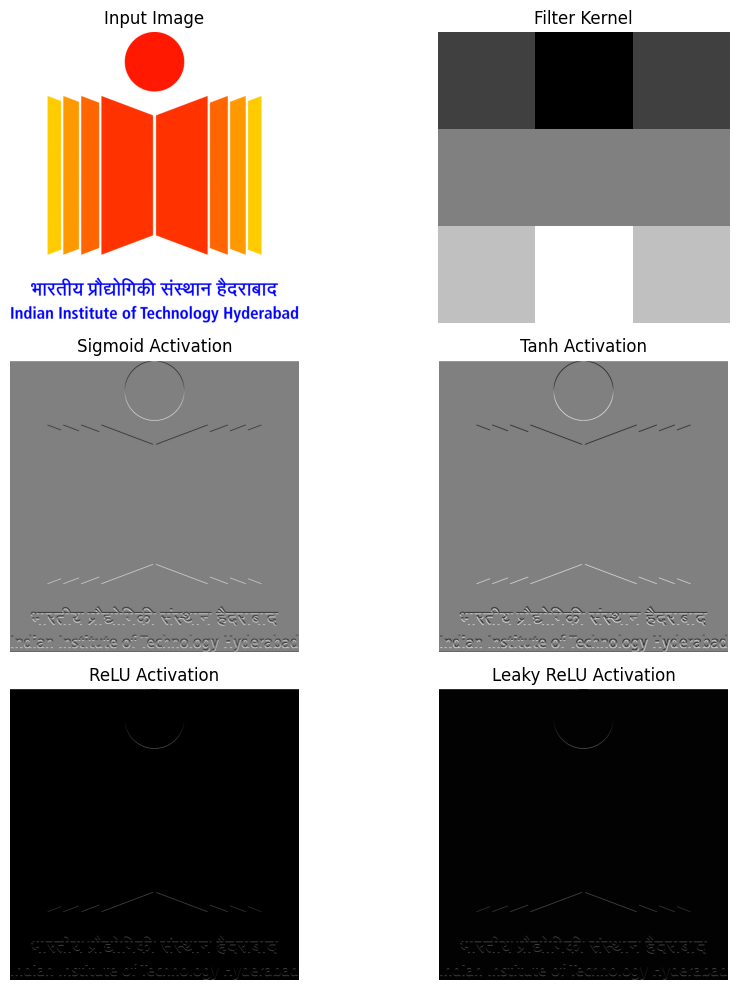

In [150]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(nor_iithlogo)
plt.title('Input Image')
plt.axis('off')

# plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 2)
plt.imshow(kernel[:,:,0], cmap='gray')
plt.title('Filter Kernel')
plt.axis('off')

# plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 3)
plt.imshow(sigmoid_output, cmap='gray')
plt.title('Sigmoid Activation')
plt.axis('off')

# plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 4)
plt.imshow(tanh_output, cmap='gray')
plt.title('Tanh Activation')
plt.axis('off')

# plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 5)
plt.imshow(relu_output, cmap='gray')
plt.title('ReLU Activation')
plt.axis('off')

# plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 6)
plt.imshow(leaky_relu_output, cmap='gray')
plt.title('Leaky ReLU Activation')
plt.axis('off')

plt.tight_layout()
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


# **Question 2 - Pooling Function**
It accepts as input the activation map output from the convolution function,
a pooling function, and stride. The function must output the appropriately pooled activation map.
Display the input activation map and the pooled output.

In [147]:
def pooling(activation_map, pooling_size, pooling_function, stride):
  # Get input activation map dimensions
  height, width = activation_map.shape

  # Calculate output dimensions
  output_height = (height - pooling_size) // stride + 1
  output_width = (width - pooling_size) // stride + 1

  # Initialize pooled output activation map
  pooled_output = np.zeros((output_height, output_width))

  # Pooling loop
  for i in range(0, height - pooling_size + 1, stride):
    for j in range(0, width - pooling_size + 1, stride):

      # Extract the receptive field for pooling
      recp_field = activation_map[i:i + pooling_size, j:j + pooling_size]

      # Apply pooling function
      if pooling_function == 'max':
        pooled_output[i // stride, j // stride] = np.max(recp_field)
      elif pooling_function == 'average':
        pooled_output[i // stride, j // stride] = np.mean(recp_field)

  return pooled_output

## **Setting parameter and calling pooling function for only relu output**

In [151]:
pooling_size = 2
pooling_function = 'max'
pooling_stride = 2

# Perform pooling on the output activation from convolution
pooled_relu_output = pooling(relu_output, pooling_size, pooling_function, pooling_stride)

print("ReLU activation output shape: ", relu_output.shape)
print("Shape after Pooling: ", pooled_relu_output.shape)

ReLU activation output shape:  (1590, 1579)
Shape after Pooling:  (795, 789)


## **Display the output**

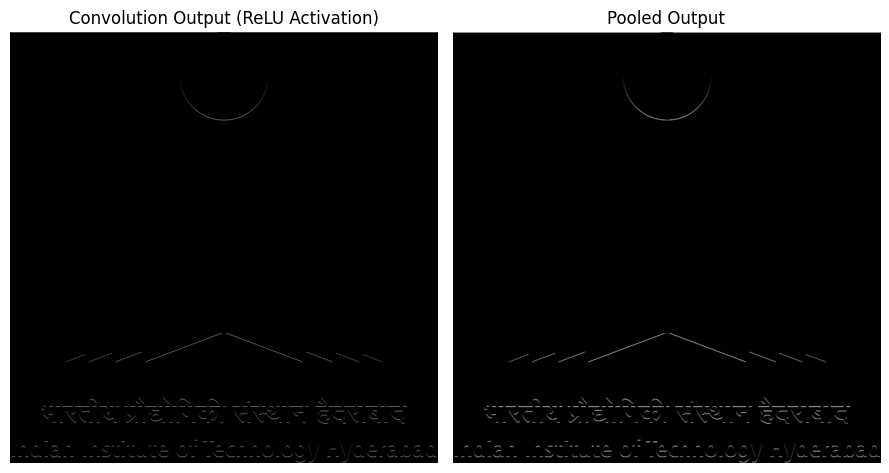

In [152]:
# Display the input activation map and the pooled output

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.imshow(relu_output, cmap='gray')
plt.title('Convolution Output (ReLU Activation)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pooled_relu_output, cmap='gray')
plt.title('Pooled Output')
plt.axis('off')

plt.tight_layout()
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


# **Question 3 - Convolution Layer Function**
It accepts as input a volume (image or activation maps), number
of filters, kernel dimensions, stride, padding, and the non-linear activation function. The function
must convolve the input volume (after padding if specified) with each kernel (at the specified stride
size) and generate an output activation volume after applying the specified non-linearity. Display
the input image or activation maps, the filter kernels, and the output activation maps. Verify that
the output of this function does indeed have the expected size (W × H × C) as discussed in class.
(3)


In [154]:
def convolution_layer(input_volume, num_filters, kernel_size, stride, padding, act_fun):
  height, width, channels = input_volume.shape
  output_height = (height - kernel_size[0] + 2*padding) // stride + 1
  output_width = (width - kernel_size[1] + 2*padding) // stride + 1

  # Initialize output activation volume
  output_volume = np.zeros((output_height, output_width, num_filters))

  # Generate random filters
  filters = np.random.randn(num_filters, kernel_size[0], kernel_size[1], channels)

  # Convolve each filter with the input volume
  for filter_index in range(num_filters):
    output_activation = convolution(input_volume, filters[filter_index], stride, padding, act_fun)
    output_volume[:, :, filter_index] = output_activation

  return output_volume, filters

In [155]:
num_filters = 3
kernel_dimensions = (5, 5)
stride_convolution_layer = 2
padding_convolution_layer = 2

# Perform convolution layer with ReLU activation
output_activation_volume, filters = convolution_layer(nor_iithlogo, num_filters, kernel_dimensions, stride_convolution_layer, padding_convolution_layer, relu)

In [156]:
print("Input image shape: ",nor_iithlogo.shape)
print("Shape After Convolution Layer: ", output_activation_volume.shape)

Input image shape:  (1590, 1579, 3)
Shape After Convolution Layer:  (795, 790, 3)


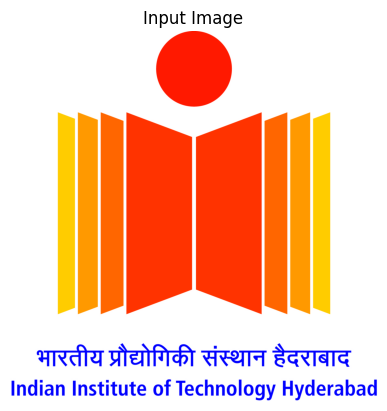

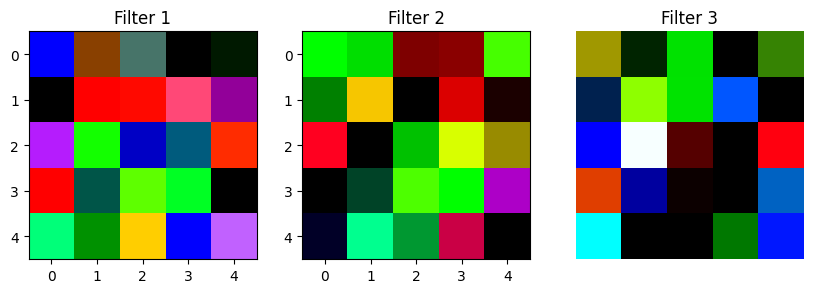

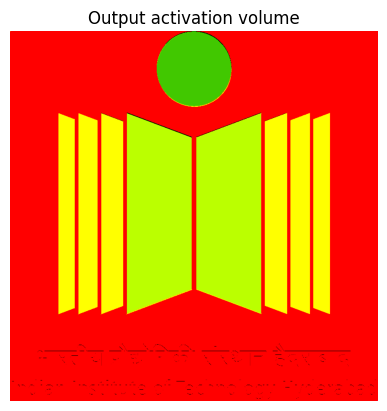

In [159]:
# Display the input image, filter kernels, and output activation maps
plt.imshow(image)
plt.title('Input Image')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
# Display filter kernels
for i in range(num_filters):
    plt.subplot(1, num_filters, i+1)
    plt.imshow(filters[i], cmap='gray')
    plt.title(f'Filter {i+1}')
plt.axis('off')
plt.show()

plt.imshow(output_activation_volume, cmap='gray')
plt.title('Output activation volume')
plt.axis('off')
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# **Question 4 - Pooling Layer Function**
It accepts as input the activation map volume, the pooling function,
stride, and generates a pooled output volume. A special case for performing Global Average Pooling
should also be provided. (2)

In [161]:
def pooling_layer(activation_map, pooling_function, stride, global_average_pooling=False):
  height, width, channels = activation_map.shape

  if global_average_pooling:
    # Global Average Pooling
    pooled_output = np.mean(activation_map, axis=(0, 1))  # Average over height and width
  else:
    # Regular pooling
    pooling_size = 2  # Assuming a pooling size of 2 (can be adjusted)
    pooled_output = np.zeros((height // stride, width // stride, channels))

    for channel in range(channels):
      pooled_output[:, :, channel] = pooling(activation_map[:, :, channel], pooling_size, pooling_function, stride)

  return pooled_output

In [162]:
# Max pooling with stride 2
pooled_output = pooling_layer(output_activation_volume, 'max', 2)

# Global average pooling with stride 1
global_pooled_output = pooling_layer(output_activation_volume, 'max', 1, global_average_pooling=True)

In [165]:
print("Activation volume shape from prev convolution layer: ", output_activation_volume.shape)
print("Shape after Max Pooling layer: ", pooled_output.shape)
print("Global Average Pooled output: ", global_pooled_output.shape)
print("GAP values: ", global_pooled_output)

Activation volume shape from prev convolution layer:  (795, 790, 3)
Shape after Max Pooling layer:  (397, 395, 3)
Global Average Pooled output:  (3,)
GAP values:  [4.72407179e+00 5.35853923e-01 1.17732343e-06]


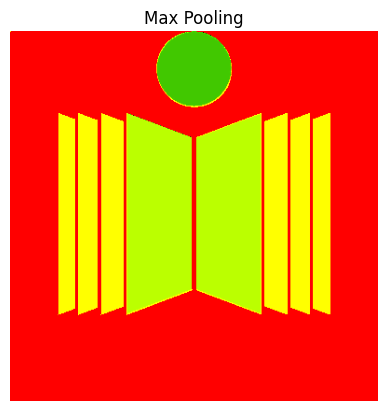

In [167]:
# Displaying the pooled output
plt.imshow(pooled_output)
plt.title('Max Pooling')
plt.axis('off')
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# **Question 5 - MLP function**
It accepts as input a vector, the number of hidden
layers, the size of each hidden layer, the non-linear function, and the size of the output layer. This
function should generate an output vector of the specified size. Generate the output with and
without the softmax function applied to the output layer. (3)


In [168]:
def relu(x):
  return np.maximum(0, x)

def softmax(x):
  exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # Subtracting np.max(x) for numerical stability
  return exp_x / np.sum(exp_x, axis=0, keepdims=True)

def mlp(input_vector, hidden_layers, hidden_layer_size, activation_function, output_size, apply_softmax=True):
  # Initialize weights and biases
  input_size = len(input_vector)
  weights = [np.random.randn(hidden_layer_size, input_size)]
  biases = [np.zeros((hidden_layer_size, 1))]

  # appending all the weights and biases between hidden layers respectively
  for i in range(hidden_layers - 1):
    weights.append(np.random.randn(hidden_layer_size, hidden_layer_size))
    biases.append(np.zeros((hidden_layer_size, 1)))

  # initialized weight and biases for last hidden layer to output layer
  output_weights = np.random.randn(output_size, hidden_layer_size)
  output_biases = np.zeros((output_size, 1))

  # Forward pass
  x = input_vector.reshape(-1, 1)

  for i in range(hidden_layers):
    x = activation_function(np.dot(weights[i], x) + biases[i])

  output = np.dot(output_weights, x) + output_biases

  # Apply softmax to the output layer if specified
  if apply_softmax:
    output = softmax(output)

  return output.flatten()

In [169]:
input_vector = np.random.randn(10)  # Input vector of size 10
hidden_layers = 2
hidden_layer_size = 10
output_size = 4
activation_function = relu

output_with_softmax = mlp(input_vector, hidden_layers, hidden_layer_size, activation_function, output_size)
output_without_softmax = mlp(input_vector, hidden_layers, hidden_layer_size, activation_function, output_size, apply_softmax=False)

print("Shape of MLP input: ", input_vector.shape)
print("Shape of MLP output: ", output_with_softmax.shape)
print("\n")
print("Output with Softmax:", output_with_softmax)
print("Output without Softmax:", output_without_softmax)

Shape of MLP input:  (10,)
Shape of MLP output:  (4,)


Output with Softmax: [1.00000000e+00 1.64018324e-34 1.10182416e-43 1.21215671e-11]
Output without Softmax: [-10.49218187  -6.83570206  12.62597538   2.52075589]


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# **Question - 6 Putting it all together**
Finally, use the functions you have written to implement a CNN with the
following architecture. The CNN must accept an image input and output a vector of appropriate
dimension. In other words, the function must effectively implement the feed-forward path in a
CNN. (5)
- Input image of size 224×224×3. Use validation images (or, random crops) from the ILSVRC
dataset.
- Convolution layer with 16 kernels of size 5 × 5 spatial dimensions and ReLU activation.
- Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
- Convolution layer with 32 kernels of spatial size 3 × 3 and sigmoid activation.
- Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
- A Global Average Pooling (GAP) layer.
- An MLP with one hidden layer (size same as input) that accepts as input the previous layer’s
output and maps it to 1000 output nodes. Use ReLU activation for the MLP (softmax in the
o/p layer).

Verify that your composition of function accepts and image input and outputs a vector.


ISLVCR:  (224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

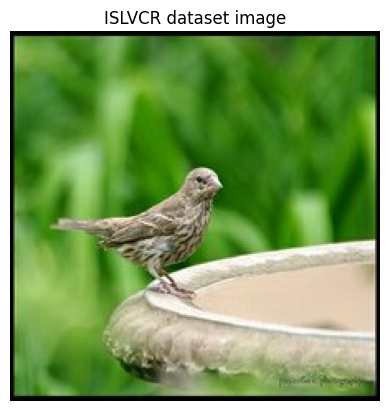

In [173]:
image_path = "ISLVCR_224x224x3.jpg"
ISLVCR = mpimg.imread(image_path)
print("ISLVCR: ", ISLVCR.shape)

# Image normalization
nor_ISLVCR = ISLVCR / 255.0

plt.imshow(nor_ISLVCR)
plt.title("ISLVCR dataset image")
plt.axis('off')

In [181]:
def CNN(input_image):

  # Convolution Layer 1
  conv1_filters = 16
  conv1_kernel_size = (5, 5)
  conv1_stride = 1
  conv1_padding = 0
  conv1_activation = relu
  conv1_output, conv1_filters = convolution_layer(input_image, conv1_filters, conv1_kernel_size, conv1_stride, conv1_padding, conv1_activation)
  print("1st Conv Layer output shape: ",conv1_output.shape)

  # Max Pooling Layer 1
  pool1_size = 2
  pool1_stride = 2
  pool1_output = pooling_layer(conv1_output, 'max', pool1_stride)
  print("1st Max Pool Layer output shape: ",pool1_output.shape)

  # Convolution Layer 2
  conv2_filters = 32
  conv2_kernel_size = (3, 3)
  conv2_stride = 1
  conv2_padding = 0
  conv2_activation = sigmoid
  conv2_output, conv2_filters = convolution_layer(pool1_output, conv2_filters, conv2_kernel_size, conv2_stride, conv2_padding, conv2_activation)
  print("2nd Conv Layer output shape: ",conv2_output.shape)

  # Max Pooling Layer 2
  pool2_size = 2
  pool2_stride = 2
  pool2_output = pooling_layer(conv2_output, 'max', pool2_stride)
  print("2nd Max Pool Layer output shape: ",pool2_output.shape)

  # Global Average Pooling Layer
  global_pool_output = pooling_layer(pool2_output, 'max', 1, global_average_pooling=True)
  print("GAP layer output shape: ",global_pool_output.shape)

  # MLP Layer
  mlp_input_size = np.prod(global_pool_output.shape)
  mlp_hidden_layers = 1
  mlp_hidden_layer_size = mlp_input_size
  mlp_output_size = 1000
  mlp_activation_function = relu
  mlp_output = mlp(global_pool_output.flatten(), mlp_hidden_layers, mlp_hidden_layer_size, mlp_activation_function, mlp_output_size)
  print("MLP Output Shape: ",mlp_output.shape)

  return mlp_output

In [182]:
# Test the CNN architecture with the provided image
print("Original image shape: ", ISLVCR.shape)
output_vector = CNN(nor_ISLVCR)
print("\n")
print("MLP Output after softmax: ")
print(output_vector)

Original image shape:  (224, 224, 3)
1st Conv Layer output shape:  (220, 220, 16)
1st Max Pool Layer output shape:  (110, 110, 16)
2nd Conv Layer output shape:  (108, 108, 32)
2nd Max Pool Layer output shape:  (54, 54, 32)
GAP layer output shape:  (32,)
MLP Output Shape:  (1000,)


MLP Output after softmax: 
[3.70645211e-22 5.56486894e-21 2.70070876e-22 3.93798131e-14
 1.26279947e-12 1.47889302e-20 7.60339274e-08 7.35571392e-19
 9.31988069e-10 5.96539282e-32 1.54415118e-20 1.27640790e-14
 4.84826632e-16 1.12487384e-22 1.39713062e-18 1.09016178e-19
 8.81375911e-21 4.19493775e-19 1.68334617e-19 7.06239285e-12
 5.57035127e-15 1.05330283e-25 9.78436680e-08 9.79220201e-14
 1.45200693e-16 3.85289637e-07 2.56194135e-19 2.38514647e-20
 2.24125216e-19 2.33960034e-22 2.72972988e-32 3.79374051e-32
 4.48756480e-19 6.87028584e-12 1.20129658e-20 6.20125844e-16
 1.08610197e-13 9.88859240e-20 4.10559399e-19 1.82469201e-21
 1.17743801e-23 3.89136880e-26 1.58192284e-18 1.18740188e-20
 9.55717015e-22 4.0

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# **Question 7 - The adding problem**
In this task, each data sample consists of a sequence of variable length,
but a constant depth (size of feature vector at each time instance) of 2. All values of the first dimension (randomly) lie in [0, 1], and the second dimension is all zeros except for two elements that
are marked by 1. The objective of the task is to sum the random values whose second dimensions
are marked by 1. Train the different RNNs (Elmon network, LSTM, and GRU) discussed in the
class and compare their performance against a baseline that always predicts a sum of 1 plotting
the learning curves and final performance. Note that you are expected to implement these models
(as opposed to using the built-in constructs).[3 (Elmon) + 7 (LSTM) + 4 (GRU)+ 6 (Dataset &
baseline & comparison) = 20]
<br>
<br>
The following table presents two data samples (x) along with their labels (y). Note that the
samples should be of different lengths (n), so the dimensions of each sample can be represented as
n × 2. Given examples have lengths of 5 and 8 respectively. You have to generate/create a big
dataset (≥ 5000) of such samples for training and testing of the RNNs.

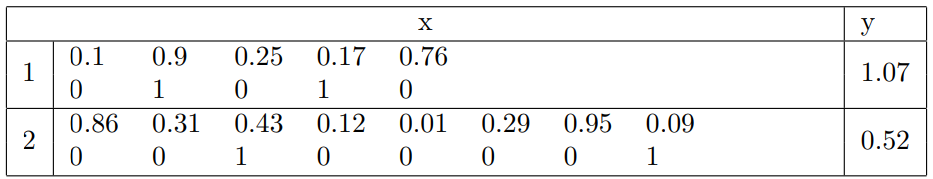

## **Generate Dataset**

In [201]:
np.random.seed(42)
torch.manual_seed(42)

def generate_dataset(no_of_samples):
  # initialized variables for dataset
  X, Y = [], []

  for i in range(int(no_of_samples)):

    # initialization of sample
    len_of_seq = np.random.randint(5, 15)
    seq = np.random.rand(len_of_seq, 2)
    seq[:, 1] = np.zeros(len_of_seq)

    # Randomly set 2 unique indices of 2nd dimension to value 1
    indices = np.random.choice(len_of_seq, size=2, replace=False)
    seq[indices, 1] = 1

    # sum values of 1st dimension whose 2nd dimension value are set to 1
    sum_indices = seq[seq[:, 1] == 1][:, 0].sum()

    # Append those 2D (sequence) values in X and 1D (sum) values in Y after converting into tensor
    X.append(torch.from_numpy(seq).double())
    Y.append(torch.from_numpy(np.array(sum_indices)))

  return np.array(X, dtype="object"), np.array(Y, dtype="object")

In [202]:
no_of_samples = 5000

# Generate dataset
X, Y = generate_dataset(no_of_samples)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

## **Set Parameters for all models (Elmon, LSTM, GRU)**

In [203]:
inp_dim = 2
hid_dim = 5
out_dim = 1
epochs = 10
learning_rate = 0.005

#### **The equations used in the Elmon, LSTM, GRU are same as mentioned by the professor in his lecture slides**
<br>
<br>
<br>


## **Elmon Network**

In [204]:
class Elmon_Network(nn.Module):
  def __init__ (self, inp_dim, hid_dim, out_dim):
    super().__init__();
    self.Wxh = nn.Linear(inp_dim, hid_dim, bias=False)
    self.Whh = nn.Linear(hid_dim, hid_dim)
    self.Why = nn.Linear(hid_dim, out_dim)
    self.double()

  def forward(self, Xt, Hprev):
    # Ht = tanh(Wxh.Xt + Whh.Hprev)
    Ht = torch.tanh(self.Wxh(Xt) + self.Whh(Hprev))
    Yt = self.Why(Ht)

    return Ht,Yt

In [205]:
Elmon = Elmon_Network(inp_dim, hid_dim, out_dim)
print(Elmon)

Elmon_Network(
  (Wxh): Linear(in_features=2, out_features=5, bias=False)
  (Whh): Linear(in_features=5, out_features=5, bias=True)
  (Why): Linear(in_features=5, out_features=1, bias=True)
)


In [206]:
# Dictionary to store losses for each epoch
Elmon_loss = {}

# Mean Squared Error (MSE) loss function
model_loss = nn.MSELoss()

# Adam optimizer with a specified learning rate
optimizer = torch.optim.Adam(Elmon.parameters(), lr=learning_rate)

for epoch in range(epochs):
  epoch_loss = []

  for X, Y in zip(X_train, Y_train):
    # Reset gradients to zero
    Elmon.zero_grad()

    # Initialization
    loss = 0
    Hprev = torch.zeros(1, hid_dim, requires_grad=False, dtype=torch.float64)

    # Forward pass through the time steps
    for i in range(X.shape[0]):
      Ht, Yt = Elmon(X[i, :], Hprev)
      Hprev = Ht

    # Calculate the mean squared error loss
    loss = model_loss(Yt, Y)

    # Compute gradients using backward pass
    loss.backward()

    # Prevent exploding gradients using Clip
    nn.utils.clip_grad_norm_(Elmon.parameters(), 3)

    # Update model parameters using the optimizer
    optimizer.step()
    epoch_loss.append(loss.detach().item())

  Elmon_loss[epoch] = torch.tensor(epoch_loss).mean()

  print(f"Epoch: {epoch + 1} | loss: {round(Elmon_loss[epoch].item(), 4)}")

Epoch: 1 | loss: 0.1308
Epoch: 2 | loss: 0.028
Epoch: 3 | loss: 0.0207
Epoch: 4 | loss: 0.0184
Epoch: 5 | loss: 0.0173
Epoch: 6 | loss: 0.0165
Epoch: 7 | loss: 0.0157
Epoch: 8 | loss: 0.0153
Epoch: 9 | loss: 0.0145
Epoch: 10 | loss: 0.0137


In [207]:
# Plot loss vs epoch (same function used further for LSTM and GRU)
def PlotLossGraph(X):
  plt.plot(X.keys(), X.values(), label='Loss')
  plt.title('Loss vs epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

Elmon Network


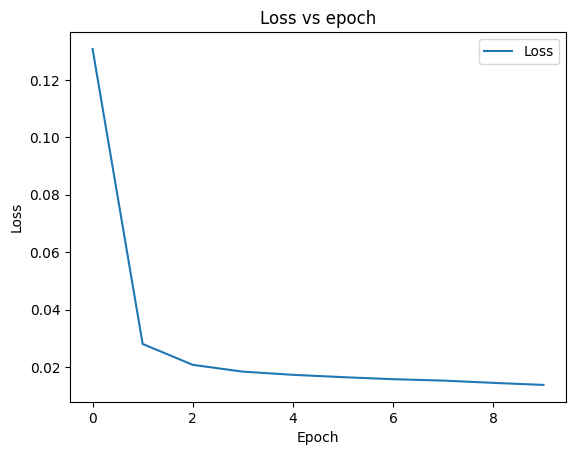

In [208]:
# Plotting loss vs epoch curve for Elmon Network
print("Elmon Network")
PlotLossGraph(Elmon_loss)

## **LSTM**

In [209]:
class LSTM_model(nn.Module):
  def __init__ (self, inp_dim, hid_dim, out_dim):
    super().__init__();

    self.Uf = nn.Linear(inp_dim, hid_dim, bias=False)
    self.Ui = nn.Linear(inp_dim, hid_dim, bias=False)
    self.Uo = nn.Linear(inp_dim, hid_dim, bias=False)
    self.U = nn.Linear(inp_dim, hid_dim, bias=False)

    self.Wf = nn.Linear(hid_dim, hid_dim)
    self.Wi = nn.Linear(hid_dim, hid_dim)
    self.Wo = nn.Linear(hid_dim, hid_dim)
    self.W = nn.Linear(hid_dim, hid_dim)

    self.V = nn.Linear(hid_dim, out_dim)
    self.double()

  def forward(self, Xt, Hprev, Cprev):
    # Forget gate = sigmoid(Ui.Xt + Wf.Hprev)
    Ft = torch.sigmoid(self.Uf(Xt) + self.Wf(Hprev))

    # Input gate = sigmoid(Ui.Xt + Wi.Hprev)
    It = torch.sigmoid(self.Ui(Xt) + self.Wi(Hprev))

    # Candidate Ct = tanh(U.Xt + W.Hprev)
    C_candi = torch.tanh(self.U(Xt) + self.W(Hprev))

    # Output gate = sigmoid(Uo.Xt + Wo.Hprev)
    Ot = torch.sigmoid(self.Uo(Xt) + self.Wo(Hprev))

    # Cell_State Ct, Hidden_state Ht
    Ct = It * C_candi + Ft * Cprev
    Ht = Ot * torch.tanh(Ct) # hidden_state to next cell
    Yt = self.V(Ht)

    return Ht, Ct, Yt

In [210]:
LSTM = LSTM_model(inp_dim, hid_dim, out_dim)
print(LSTM)

LSTM_model(
  (Uf): Linear(in_features=2, out_features=5, bias=False)
  (Ui): Linear(in_features=2, out_features=5, bias=False)
  (Uo): Linear(in_features=2, out_features=5, bias=False)
  (U): Linear(in_features=2, out_features=5, bias=False)
  (Wf): Linear(in_features=5, out_features=5, bias=True)
  (Wi): Linear(in_features=5, out_features=5, bias=True)
  (Wo): Linear(in_features=5, out_features=5, bias=True)
  (W): Linear(in_features=5, out_features=5, bias=True)
  (V): Linear(in_features=5, out_features=1, bias=True)
)


In [211]:
# Just the initialization and forward pass are different from the Elmon Network training
LSTM_loss = {}
model_loss = nn.MSELoss();
optimizer = torch.optim.Adam(LSTM.parameters(), lr = learning_rate)

for epoch in range(epochs):
  epoch_loss = list()

  for X, Y in zip(X_train, Y_train):
    LSTM.zero_grad()
    loss = 0

    Hprev = torch.zeros(1, hid_dim, requires_grad=False, dtype=torch.float64)
    Cprev = torch.zeros(1, hid_dim, requires_grad=False, dtype=torch.float64)

    # Forward pass through the time steps in LSTM
    for i in range(X.shape[0]):
      Ht, Ct, Yt = LSTM(X[i,:], Hprev, Cprev)
      Hprev = Ht
      Cprev = Ct

    loss = model_loss(Yt, Y)
    loss.backward()
    nn.utils.clip_grad_norm_(LSTM.parameters(), 3)
    optimizer.step()
    epoch_loss.append(loss.detach().item())

  LSTM_loss[epoch] = torch.tensor(epoch_loss).mean()

  print(f"Epoch: {epoch+ 1} | loss: {round(LSTM_loss[epoch].item(), 4)}")

Epoch: 1 | loss: 0.0624
Epoch: 2 | loss: 0.0043
Epoch: 3 | loss: 0.0029
Epoch: 4 | loss: 0.002
Epoch: 5 | loss: 0.0015
Epoch: 6 | loss: 0.0011
Epoch: 7 | loss: 0.0009
Epoch: 8 | loss: 0.0007
Epoch: 9 | loss: 0.0006
Epoch: 10 | loss: 0.0005


LSTM


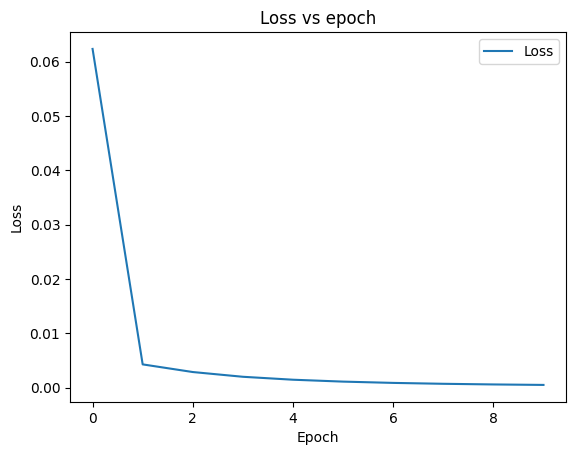

In [212]:
print("LSTM")
PlotLossGraph(LSTM_loss)

## **GRU**

In [213]:
class GRU_model(nn.Module):
  def __init__ (self, inp_dim, hid_dim, out_dim):
    super().__init__();

    self.Ur = nn.Linear(inp_dim, hid_dim, bias=False)
    self.Uo = nn.Linear(inp_dim, hid_dim, bias=False)
    self.U = nn.Linear(inp_dim, hid_dim, bias=False)

    self.Wr = nn.Linear(hid_dim, hid_dim)
    self.Wo = nn.Linear(hid_dim, hid_dim)
    self.W = nn.Linear(hid_dim, hid_dim)

    self.V = nn.Linear(hid_dim, out_dim)
    self.double()

  def forward(self, Xt, Hprev):
    # Reset Gate
    Rt = torch.sigmoid(self.Ur(Xt) + self.Wr(Hprev))

    # Output Gate
    Zt = torch.sigmoid(self.Uo(Xt) + self.Wo(Hprev))

    # Candidate Ht
    H_candi = torch.tanh(self.U(Xt) + self.W(Rt * Hprev))

    Ht = Zt * H_candi + (1-Zt) * Hprev
    Yt = self.V(Ht)

    return Ht, Yt

In [214]:
GRU = GRU_model(inp_dim, hid_dim, out_dim)
print(GRU)

GRU_model(
  (Ur): Linear(in_features=2, out_features=5, bias=False)
  (Uo): Linear(in_features=2, out_features=5, bias=False)
  (U): Linear(in_features=2, out_features=5, bias=False)
  (Wr): Linear(in_features=5, out_features=5, bias=True)
  (Wo): Linear(in_features=5, out_features=5, bias=True)
  (W): Linear(in_features=5, out_features=5, bias=True)
  (V): Linear(in_features=5, out_features=1, bias=True)
)


In [215]:
# Just the initialization and forward pass are different from the Elmon Network training
GRU_loss = {}
model_loss = nn.MSELoss();
optimizer = torch.optim.Adam(GRU.parameters(), lr = learning_rate)

for epoch in range(epochs):
  epoch_loss = list()
  for X, Y in zip(X_train,Y_train):
    GRU.zero_grad()
    loss = 0
    H_previous = torch.zeros(1, hid_dim, requires_grad=False, dtype=torch.float64)

    # Forward pass through the time steps in GRU
    for i in range(X.shape[0]):
      Ht, Yt = GRU(X[i,:],H_previous)
      H_previous = Ht

    loss = model_loss(Yt, Y)
    loss.backward()
    nn.utils.clip_grad_norm_(GRU.parameters(), 3)
    optimizer.step()
    epoch_loss.append(loss.detach().item())

  GRU_loss[epoch] = torch.tensor(epoch_loss).mean()

  print(f"Epoch: {epoch+ 1} | loss: {round(LSTM_loss[epoch].item(), 4)}")

Epoch: 1 | loss: 0.0624
Epoch: 2 | loss: 0.0043
Epoch: 3 | loss: 0.0029
Epoch: 4 | loss: 0.002
Epoch: 5 | loss: 0.0015
Epoch: 6 | loss: 0.0011
Epoch: 7 | loss: 0.0009
Epoch: 8 | loss: 0.0007
Epoch: 9 | loss: 0.0006
Epoch: 10 | loss: 0.0005


GRU


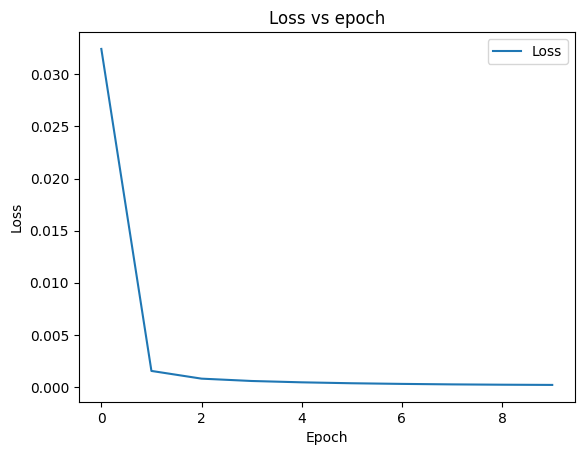

In [216]:
print("GRU")
PlotLossGraph(GRU_loss)

## **Comparison of Elmon, LSTM, GRU w.r.t to Baseline**

In [219]:
# Calculating Baseline
base = {}
for epoch in range(epochs):
  e_base = list()
  for X, Y in zip(X_train, Y_train):
    base_loss = model_loss(torch.tensor(1), Y)
    e_base.append(base_loss.detach().item())
  base[epoch] = torch.tensor(e_base).mean()

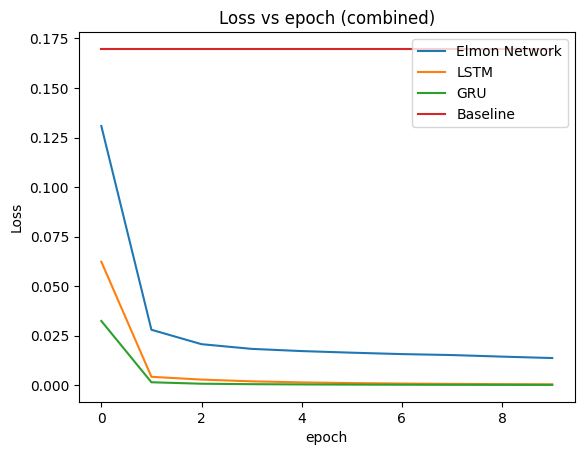

In [220]:
# Plotting all the models loss vs epoch for comparison
plt.plot(Elmon_loss.keys(),Elmon_loss.values(),  label='Elmon Network')
plt.plot(LSTM_loss.keys(),LSTM_loss.values(), label='LSTM')
plt.plot(GRU_loss.keys(),GRU_loss.values(), label='GRU')
plt.plot(base.keys(),base.values(), label='Baseline')
plt.title('Loss vs epoch (combined)')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()